# Hyperparameter Tuning - Sub model 1

## Load 3 Datasets

In [ ]:
import pandas as pd

# Load datasets
TB_HC_OD = pd.read_csv(r'..\..\Datasets\train\balanced\TB_HC_OD.csv')
PTB_EPTB = pd.read_csv(r'..\..\Datasets\train\balanced\PTB_EPTB.csv')
ATB_LTB = pd.read_csv(r'..\..\Datasets\train\balanced\ATB_LTB.csv')

## Separate features and target

In [2]:
# Separate features and target in each dataset
X_TB_HC_OD = TB_HC_OD.drop(columns=['TB_Status'])
y_TB_HC_OD = TB_HC_OD['TB_Status']

X_PTB_EPTB = PTB_EPTB.drop(columns=['TB_Status'])
y_PTB_EPTB = PTB_EPTB['TB_Status']

X_ATB_LTB = ATB_LTB.drop(columns=['TB_Status'])
y_ATB_LTB = ATB_LTB['TB_Status']

## Functions to select the best models with best hyperparameters

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [4]:
# Define models and hyperparameter grids
models = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "learning_rate": [0.1, 0.2],
            "n_estimators": [50, 100],
            "max_depth": [3, 5]
        }
    },
    "Naive Bayes": {
        "model": GaussianNB(),
        "params": {}
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {
            "learning_rate": [0.1, 0.2],
            "n_estimators": [100, 200],
            "max_depth": [-1, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "learning_rate": [0.1, 0.2],
            "n_estimators": [100, 200],
            "max_depth": [3, 5]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    }
}

In [5]:
def tune_and_evaluate(X_train, y_train, X_test, y_test, model_dict):
    results = []
    best_models = {}

    for name, model_info in model_dict.items():
        print(f"Tuning {name}...")

        # Apply GridSearchCV with early stopping for tree-based models
        if "early_stopping_rounds" in model_info["params"]:
            model_info["params"].pop("early_stopping_rounds")

        grid_search = GridSearchCV(model_info["model"], model_info["params"], cv=5, scoring='f1_weighted', verbose=1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_models[name] = best_model

        # Evaluate on test data
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Best Hyperparameters": str(best_params)
        })

    return pd.DataFrame(results), best_models

def visualize_results(results_df, title):
    results_df.set_index("Model", inplace=True)
    results_df.drop(columns="Best Hyperparameters", inplace=True)  # Remove hyperparameters column for visualization
    results_df.plot(kind='bar', figsize=(12, 6), rot=0, colormap='viridis')
    plt.title(title)
    plt.ylabel("Score")
    plt.xlabel("Model")
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


## Comparison between different algorithms for Sub model 1

c:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\dilan\anaconda3\envs\myenv\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\dilan\anaconda3\envs\myenv\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\dilan\anaconda3\envs\myenv\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executabl

Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuning Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tuning LightGBM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuning XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [07:37:01] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [07:39:33] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [07:42:04] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\dilan\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [07:44:33] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner

Tuning KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Tuning SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Overall Best Model:
Model: SVM
Accuracy: 0.8843
Precision: 0.8857
Recall: 0.8843
F1 Score: 0.8839
Best Hyperparameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


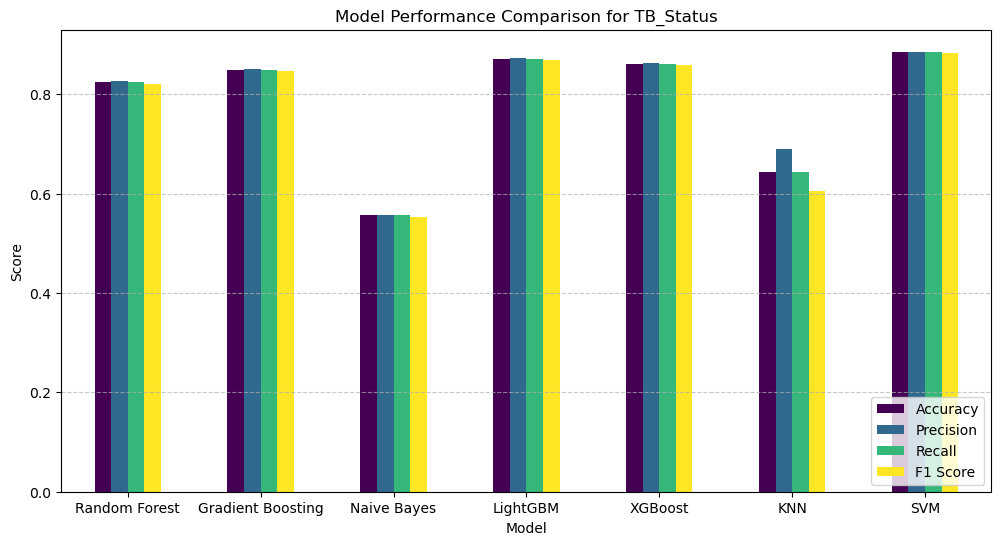

In [6]:
# Load selected features for sub-model 1
selected_features_path = r'..\..\Saved_files\selected_features_TB_HC_OD.csv'
selected_features = pd.read_csv(selected_features_path)

# Example pipeline for TB_Status
X_train_TB_Status, X_test_TB_Status, y_train_TB_Status, y_test_TB_Status = train_test_split(
    X_TB_HC_OD, y_TB_HC_OD, test_size=0.2, random_state=42
)

# SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_TB_Status_balanced, y_train_TB_Status_balanced = smote.fit_resample(X_train_TB_Status, y_train_TB_Status)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_TB_Status_balanced)
X_test_scaled = scaler.transform(X_test_TB_Status)

# Label encoding (fit the encoder on the training data first, then transform both)
label_encoder_TB_Status = LabelEncoder()
y_train_encoded = label_encoder_TB_Status.fit_transform(y_train_TB_Status_balanced)
y_test_encoded = label_encoder_TB_Status.transform(y_test_TB_Status)

# Tune and evaluate
results_TB_Status, best_models_TB_Status = tune_and_evaluate(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, models)

# Identify and visualize the best model
best_model_overall = results_TB_Status.loc[results_TB_Status["F1 Score"].idxmax()]
print("\nOverall Best Model:")
print(f"Model: {best_model_overall['Model']}")
print(f"Accuracy: {best_model_overall['Accuracy']:.4f}")
print(f"Precision: {best_model_overall['Precision']:.4f}")
print(f"Recall: {best_model_overall['Recall']:.4f}")
print(f"F1 Score: {best_model_overall['F1 Score']:.4f}")
print(f"Best Hyperparameters: {best_model_overall['Best Hyperparameters']}")

visualize_results(results_TB_Status, "Model Performance Comparison for TB_Status")
